In [1]:
%matplotlib inline

Automatically created module for IPython interactive environment
n_digits: 10, 	 n_samples 1797, 	 n_features 64


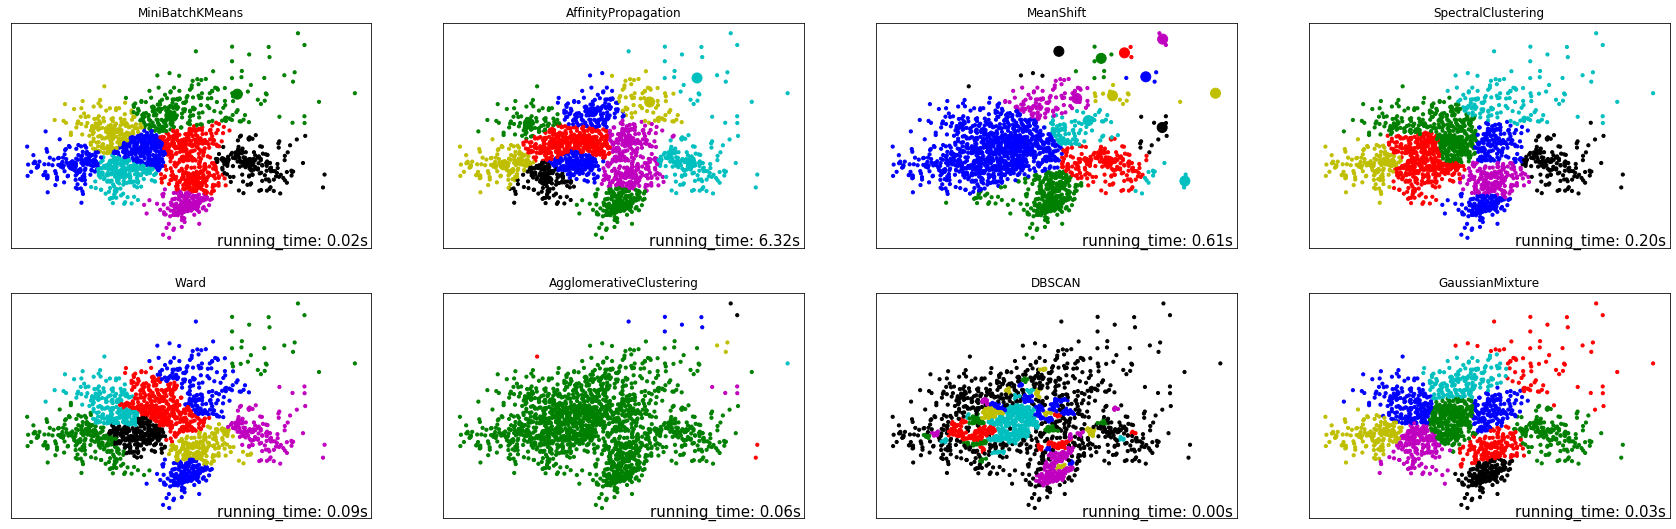

In [2]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import cluster
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics

np.random.seed(0)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'GaussianMixture']

plt.figure(figsize=(len(clustering_names)*3, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.1, top=.96, wspace=.2,
                    hspace=.2)

plot_num = 1
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

X = PCA(n_components=2).fit_transform(data)

# quantile : [0,1] ,这里我尝试了0.01到0.9，发现大于0.2的时候聚类结果只有一个簇
bandwidth = cluster.estimate_bandwidth(X, quantile=0.05)

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)


# clusters，各种聚类算法的调用
mean_shift = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ten_means = cluster.MiniBatchKMeans(n_clusters=10)

spectral = cluster.SpectralClustering(n_clusters=10,eigen_solver='arpack',
                                    affinity="nearest_neighbors") 
dbscan = cluster.DBSCAN(eps=0.2, min_samples=5)
affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

# linkage: "ward", "complete", "average"，再这个数据集中，ward效果最好
ward = cluster.AgglomerativeClustering(n_clusters=10, linkage='ward', 
                                      connectivity=connectivity)
average_linkage = cluster.AgglomerativeClustering(linkage="average", 
                                                  affinity="euclidean", n_clusters=10,
                                                  connectivity=connectivity)
gmm = GaussianMixture(n_components=10)
clustering_algorithms = [ten_means, affinity_propagation, mean_shift, spectral, ward, 
                         average_linkage, dbscan, gmm]

for name, algorithm in zip(clustering_names, clustering_algorithms):

        t0 = time()
        algorithm.fit(X)
        t1 = time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(2, len(clustering_algorithms)/2, plot_num)
        plt.title(name)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.title(name)
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)

        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('running_time: %.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
plt.show()